In [1]:
%reset -f
%matplotlib inline

import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
dirToInclude=parentdir +'/features/'
sys.path.insert(0,dirToInclude)


import pandas
import numpy as np
import pandas as pd
from sklearn import cross_validation
from sklearn import metrics
from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc
from sklearn.cross_validation import StratifiedKFold, ShuffleSplit, cross_val_score, train_test_split
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

import scipy as sp
import theano.tensor as t

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [9]:
with pm.Model() as model:
    category = pm.Categorical(name='category',
                                 p=np.array([.25,.5,.25]))
    trace = pm.sample(20, step=pm.Metropolis())
print(trace['category'])

Only 20 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [category]
Sampling 2 chains: 100%|██████████| 1040/1040 [00:00<00:00, 5376.12draws/s]


[1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1
 1 1 1]


/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py:476: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")


In [12]:
with pm.Model() as model:
    category = pm.Multinomial(name='multinomial', n =1,
                                 p=np.array([.25,.5,.25]))
    trace = pm.sample(20, step=pm.Metropolis())
print(trace['multinomial'])

TypeError: For compute_test_value, one input test value does not have the requested type.

The error when converting the test value to that variable type:
Wrong number of dimensions: expected 0, got 1 with shape (3,).

In [3]:
np.array([.25,.5,.25])

array([0.25, 0.5 , 0.25])

In [4]:
data = pd.read_csv("../Data/cns_data.csv")
rf_results = pd.read_csv("Outputs/rf_results.csv")

In [5]:
var = rf_results
#Keep only what we are using
var = var.loc[:,['CMalaria','Mening','Enceph','glasgtot','sbp','diag','patientid']]
var = var.dropna()
var.shape

(361, 7)

In [6]:
y = var['diag']
x = var[['CMalaria','Mening','Enceph','glasgtot','sbp']]
patid = var['patientid']

In [7]:
with pm.Model() as logistic_model:
    μ = pm.Normal('μ', 0, sd=10)
    effects = pm.Normal('effects', mu=0, sd=10, shape=x.shape[1])
    
    # expected parameter
    p = pm.math.invlogit(μ + t.dot(x, effects))
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Categorical('Y_obs', p=p, observed=y)

with logistic_model:
    trace = pm.sample(1000, tune=2000, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [effects, μ]
100%|██████████| 3000/3000 [01:18<00:00, 38.04it/s]
The acceptance probability does not match the target. It is 0.8812401994429406, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11c253b70>,
      dtype=object)

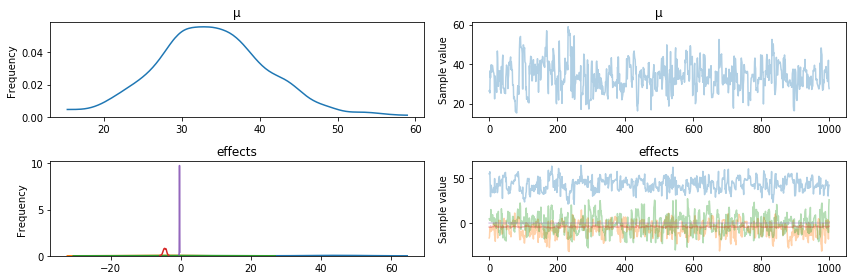

In [25]:
pm.traceplot(trace)

In [8]:
y

0      0.0
1      0.0
2      5.0
3      0.0
4      0.0
5      0.0
6      0.0
7      1.0
8      0.0
9      1.0
10     1.0
11     5.0
12     0.0
13     5.0
14     1.0
15     5.0
16     1.0
17     5.0
18     5.0
19     5.0
20     5.0
21     5.0
22     0.0
23     5.0
24     0.0
25     1.0
26     5.0
27     5.0
28     5.0
29     0.0
      ... 
331    5.0
332    1.0
333    5.0
334    0.0
335    0.0
336    0.0
337    1.0
338    5.0
339    0.0
340    5.0
341    5.0
342    5.0
343    5.0
344    5.0
345    0.0
346    5.0
347    4.0
348    0.0
349    1.0
350    0.0
351    5.0
352    1.0
353    0.0
354    1.0
355    0.0
356    5.0
357    1.0
358    0.0
359    5.0
360    5.0
Name: diag, Length: 361, dtype: float64